# Feature Engineering

Preparo el dataset para ser posteriormente usado en el modelo

Indicadores a utilizar:

* Percentage price oscilator (PPO)
* Moving average convergence/divergence (MACD)
* Normalized average true range (NATR)
* Normalized average true range (ATR)
* Relative Strenght index (RSI)
* Bollinger Bands
* Betas
* Pronostico por series de tiempo
* Regresion Lineal (Angulo y pronostico)
* Varianza

## Unimos los tickers

In [1]:
# !pip install ta-lib

In [2]:
from talib import PPO, MACD, NATR, ATR, RSI, BBANDS, BETA, TSF, LINEARREG_ANGLE, LINEARREG

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
#from talib import MACD, PPO, MACD, NATR, RSI, BBANDS, SMA, ATR
from tqdm import tqdm

tqdm.pandas()

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Indexamos por ticker para facilitar calculos

In [4]:
dataset = pd.read_pickle("data/all_tickers_raw.pkl")
dataset.sort_index(inplace = True)
dataset.set_index('Ticker', append = True, inplace = True)
dataset.head()

Open      High       Low     Close  Adj Close  \
Date       Ticker                                                      
1962-01-02 MO      0.000000  0.191840  0.189236  0.189236   0.000222   
           IBM     7.713333  7.713333  7.626667  7.626667   0.602089   
           PG      0.000000  1.441406  1.421875  1.429688   0.013336   
           IP      0.000000  9.064277  8.852777  8.852777   0.752891   
           XOM     0.000000  1.589844  1.578125  1.578125   0.013385   

                     Volume Currency  
Date       Ticker                     
1962-01-02 MO      345600.0      USD  
           IBM     387200.0      USD  
           PG      192000.0      USD  
           IP       48600.0      USD  
           XOM     902400.0      USD

## Calculamos indicadores

### Compute Moving Average Convergence/Divergence (MACD)

In [5]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd

dataset["MACD"] = dataset.groupby('Ticker', level = 2).Close.apply(compute_macd)

In [6]:
alua_mask = dataset.index.get_level_values('Ticker') == "ALUA.BA"

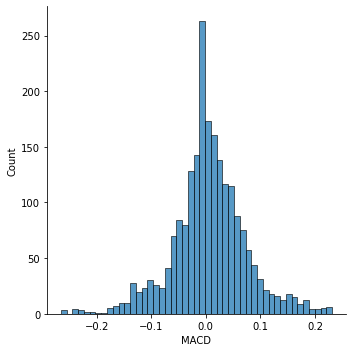

In [7]:
sns.displot(data = dataset[alua_mask], x = "MACD")

### Relative Strength Index (RSI)

In [8]:
dataset["RSI"] = dataset.groupby('Ticker').Close.apply(RSI)

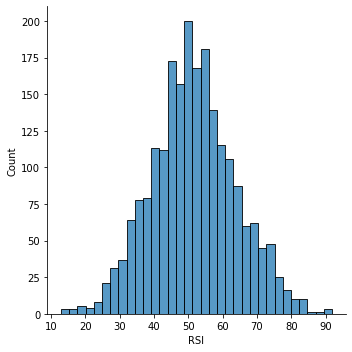

In [9]:
sns.displot(data = dataset[alua_mask], x = "RSI")

### Bollinger Bands

In [10]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'BB_High': high, 'BB_Mid': mid, 'BB_Low': low}, index=close.index)

In [11]:
bollinger_bands = dataset.groupby('Ticker').Close.apply(compute_bb)
dataset = dataset.join(bollinger_bands)

### Average True Range

In [12]:
def compute_atr(stock_data):
    return ATR(stock_data.High, 
              stock_data.Low, 
              stock_data.Close, 
              timeperiod=14)

In [13]:
dataset["ATR"] = dataset.groupby("Ticker", group_keys=False).apply(compute_atr)

### Normalized average true range

In [14]:
dataset["NATR"] = dataset.groupby("Ticker", group_keys=False).apply(lambda x: NATR(high=x.High, low=x.Low, close=x.Close))

### Volumen en moneda

In [15]:
dataset["Currency_Volume"] = dataset.loc[:, 'Close'].mul(dataset.loc[:, 'Volume'], axis=0)

### Retorno mensual, bimensual y trimestral

In [16]:
def remove_outliers(x):
    return x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99))

In [17]:
dataset["Return_1w"] = dataset.sort_index().groupby("Ticker").Close.pct_change(7).pipe(remove_outliers)
dataset["Return_1m"] = dataset.sort_index().groupby("Ticker").Close.pct_change(30).pipe(remove_outliers)
dataset["Return_2m"] = dataset.sort_index().groupby("Ticker").Close.pct_change(60).pipe(remove_outliers)
dataset["Return_3m"] = dataset.sort_index().groupby("Ticker").Close.pct_change(90).pipe(remove_outliers)

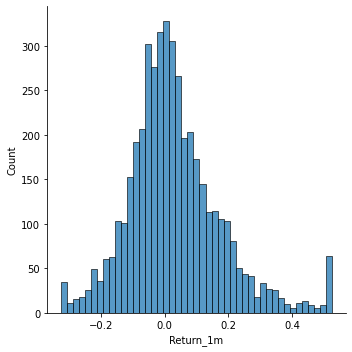

In [18]:
sns.displot(data = dataset[alua_mask], x = "Return_1m")

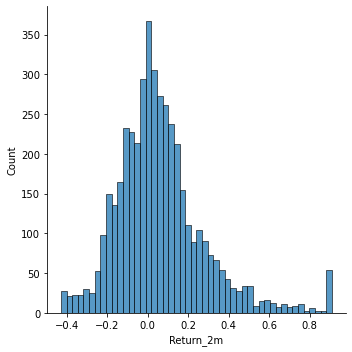

In [19]:
sns.displot(data = dataset[alua_mask], x = "Return_2m")

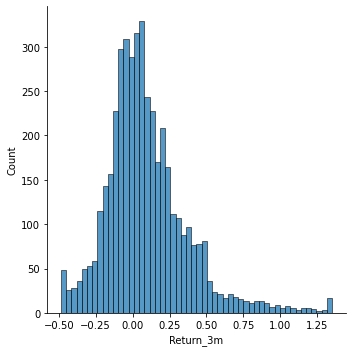

In [20]:
sns.displot(data = dataset[alua_mask], x = "Return_3m")

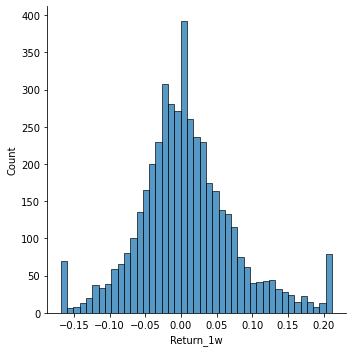

In [21]:
sns.displot(data = dataset[alua_mask], x = "Return_1w")

### Confección de target con features

Utilizando el % de diferencia a 1, 2 y 3 meses confeccionamos el target, moviendo el periodo de holding hacia el pasado.

In [22]:
dataset["Forward_Return_1w"] = dataset.groupby('Ticker')[f'Return_1w'].shift(-7)
dataset["Forward_Return_1m"] = dataset.groupby('Ticker')[f'Return_1m'].shift(-30)
dataset["Forward_Return_2m"] = dataset.groupby('Ticker')[f'Return_2m'].shift(-60)
dataset["Forward_Return_3m"] = dataset.groupby('Ticker')[f'Return_3m'].shift(-90)

Creamos feature de fechas

In [23]:
dataset['Year'] = dataset.apply(lambda frame: frame.index.get_level_values(0).year).Close
dataset['Month'] = dataset.apply(lambda frame: frame.index.get_level_values(0).month).Close
dataset['Weekday'] = dataset.apply(lambda frame: frame.index.get_level_values(0).weekday).Close

## Betas

In [24]:
def compute_beta(stock_data):
    return BETA(stock_data.High, stock_data.Low)

dataset['BETA'] = dataset.groupby("Ticker", group_keys=False).apply(compute_beta)

## Pronostico de series de tiempo

In [25]:
def compute_forecast_for_timeperiod(timeperiod = 7):
    return lambda data: TSF(data.Close, timeperiod = timeperiod)

dataset['TSF_7'] = dataset.groupby("Ticker", group_keys=False).apply(compute_forecast_for_timeperiod(7))
dataset['TSF_14'] = dataset.groupby("Ticker", group_keys=False).apply(compute_forecast_for_timeperiod(14))
dataset['TSF_28'] = dataset.groupby("Ticker", group_keys=False).apply(compute_forecast_for_timeperiod(28))

## Angulo de la regresion lineal

In [26]:
def compute_lineal_reg_angle_for_period(timeperiod = 7):
    return lambda data: LINEARREG_ANGLE (data.Close, timeperiod = timeperiod)

dataset['Angle_7'] = dataset.groupby("Ticker", group_keys=False).apply(compute_lineal_reg_angle_for_period(7))
dataset['Angle_14'] = dataset.groupby("Ticker", group_keys=False).apply(compute_lineal_reg_angle_for_period(14))
dataset['Angle_28'] = dataset.groupby("Ticker", group_keys=False).apply(compute_lineal_reg_angle_for_period(28))

## Pronostico de regresiones lineales

In [27]:
def compute_lineal_reg_period(timeperiod = 7):
    return lambda data: LINEARREG(data.Close, timeperiod = timeperiod)

dataset['Reg_7'] = dataset.groupby("Ticker", group_keys=False).apply(compute_lineal_reg_period(7))
dataset['Reg_14'] = dataset.groupby("Ticker", group_keys=False).apply(compute_lineal_reg_period(14))
dataset['Reg_28'] = dataset.groupby("Ticker", group_keys=False).apply(compute_lineal_reg_period(28))

## Formateo

Eliminamos los indices de ticker para llevarlos a sus respectivas columnas

In [28]:
dataset.reset_index(inplace = True, level = 1)
dataset.sample(5)

,Ticker,Open,High,Low,Close,Adj Close,Volume,Currency,MACD,RSI,...,BETA,TSF_7,TSF_14,TSF_28,Angle_7,Angle_14,Angle_28,Reg_7,Reg_14,Reg_28
Date,,,,,,,,,,,,,,,,,,,,,
2003-09-10,CL,27.924999,28.295000,27.924999,28.020000,15.214726,2581000.0,USD,8.867913e-02,54.995562,...,0.443315,28.033572,28.521264,27.959921,-1.217339,6.510482,1.584089,28.054822,28.407143,27.932266
1994-03-10,KGC,12.375000,12.562500,11.625000,12.562500,11.943150,23300.0,USD,4.021487e-01,74.943178,...,0.459787,12.816964,11.317995,10.290179,29.648377,9.933882,1.142060,12.247768,11.142857,10.270243
2018-09-20,X.BA,243.000000,243.000000,243.000000,243.000000,242.911545,0.0,ARS,1.667217e-04,99.999669,...,0.000000,243.000000,243.000000,243.000000,-0.000000,-0.000000,-0.000000,243.000000,243.000000,243.000000
2015-07-30,SBUX,57.299999,58.150002,57.009998,58.060001,52.720913,7337900.0,USD,1.110322e+00,74.955893,...,0.336880,58.012857,57.882198,57.540318,11.820578,10.515913,8.937323,57.803571,57.696571,57.383054
2020-02-19,CL.BA,340.000000,340.000000,340.000000,340.000000,340.000000,0.0,ARS,1.705303e-13,0.000000,...,0.000000,340.000000,340.000000,340.000000,-0.000000,-0.000000,-0.000000,340.000000,340.000000,340.000000


Ordenamos por fecha para evitar esta reingenieria durante los procesos de entrenamiento e iteracion de modelos

In [29]:
dataset.sort_index(inplace = True)
dataset.index.is_monotonic

True

### Salvado de los datos

In [30]:
dataset.shape

(1963395, 37)

In [31]:
dataset.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1963395 entries, 1962-01-02 to 2020-10-16
Data columns (total 37 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Ticker             1963395 non-null  object 
 1   Open               1962118 non-null  float64
 2   High               1962118 non-null  float64
 3   Low                1962118 non-null  float64
 4   Close              1962118 non-null  float64
 5   Adj Close          1962118 non-null  float64
 6   Volume             1962118 non-null  float64
 7   Currency           1963395 non-null  object 
 8   MACD               1724870 non-null  float64
 9   RSI                1731977 non-null  float64
 10  BB_High            1730095 non-null  float64
 11  BB_Mid             1730095 non-null  float64
 12  BB_Low             1730095 non-null  float64
 13  ATR                1731977 non-null  float64
 14  NATR               1731977 non-null  float64
 15  Currency_Volume  

In [32]:
dataset.dropna(inplace = True)

In [33]:
dataset.shape

(1675499, 37)

In [36]:
dataset.to_csv("data/all_tickers_features.csv")

In [37]:
dataset = dataset[dataset.index > '2010-01-01']
dataset.to_csv("data/all_tickers_last_decade_features.csv")

## Division en train y test

In [38]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, train_size = 0.8, random_state = 42, shuffle = False)

In [39]:
train.to_csv("data/raw_train_data.csv")
test.to_csv("data/raw_test_data.csv")

In [40]:
train.shape

(528788, 37)

In [43]:
train.index[0], train.index[-1]

(Timestamp('2010-01-04 00:00:00'), Timestamp('2018-07-27 00:00:00'))

In [41]:
test.shape

(132197, 37)

In [42]:
test.index[0], test.index[-1]

(Timestamp('2018-07-27 00:00:00'), Timestamp('2020-06-10 00:00:00'))